In [1]:
import sys
sys.path.append("/home/mette/github/odl")
import odl
from algorithmImpls import *
import numpy as np
from os import listdir
from os.path import isfile, join
from tqdm import tqdm

In [2]:
def theta_from_t(t, frames=240, pis = 8):
    alpha = pis*np.pi/frames
    return alpha*t-np.pi/6

In [3]:
def load_volume(filepath):
    files = [file for file in np.sort(listdir(filepath)) if file.endswith(".npy")]
    height, width = np.load(join(filepath,files[0])).shape
    depth = len(files)
    volume = np.zeros((depth, height, width))
    for i,file in tqdm(enumerate(files)):
        volume[i,:,:] = np.load(join(filepath,file))

    volume = volume[:,:,:].astype('float32')
    return volume


In [4]:
volume = load_volume("../PhantomGenerator/output/slow_fast")
volume = volume[:,32:480,32:480].astype('float32')
volume.shape
volume2D = np.sum(volume, axis = 1)

240it [00:00, 514.46it/s]


In [5]:
num_angles = 30#number of angles pr. frame
num_angles_pi = 30 #number of angles for one full rotation

frames, szrow, szcol = volume.shape#-num_angles#210#this is number of frames we can reconstruct

strt_stp_idx = int(num_angles/2)
frame_idx = np.array((range(0,frames)))
frames_to_reconstruct = np.array([30, 50, 175, 200])

In [6]:

lamda1 = 0.001
lamda2 = 1.0

#to save time lets just use frames 0-100. Should be enough. We're only looking at frame 50 and most movement occurs frame 40-60, meaning by using angles 0-100 we get 40 angles with very little movement and we're using 30 for reconstructing each frame
fs=[35,50,65]
frame_used_in_recon = 100
sz = 300
ts = range(0,frame_used_in_recon)
thetas_all = np.array([theta_from_t(t) for t in ts]) #angles for full acquisition
detector_partition = odl.uniform_partition(-30, 30, 448)
reconstruction_space = odl.uniform_discr(min_pt=[-20, -20, 0], max_pt=[20, 20, 20], shape=[sz, sz, frame_used_in_recon-num_angles], dtype='float32')

recon_t = np.zeros((len(fs), sz,sz))

x, sinogram_spaces = TVReconTime(volume2D[0:frame_used_in_recon], reconstruction_space, lamda1, lamda2, frame_used_in_recon-num_angles, thetas_all, num_angles, num_angles_pi, detector_partition)

for i,f in enumerate(fs):
    recon_t[i,:,:] = np.transpose(x.data, (2,0,1))[f-int(num_angles/2)-1]

/home/mette/anaconda3/envs/py38/lib/python3.8/site-packages/scipy/sparse/sputils.py:114: UserWarning: object dtype is not supported by sparse matrices
  warnings.warn("object dtype is not supported by sparse matrices")
/home/mette/anaconda3/envs/py38/lib/python3.8/site-packages/scipy/sparse/sputils.py:114: UserWarning: object dtype is not supported by sparse matrices
  warnings.warn("object dtype is not supported by sparse matrices")


Text(0.5, 1.0, '65')

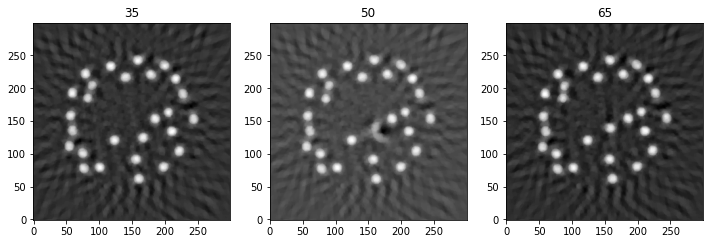

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(1,3, figsize=(12,12))
ax[0].imshow(recon_t[0,:,:], cmap="gray", origin="lower")
ax[0].set_title(fs[0])

ax[1].imshow(recon_t[1,:,:], cmap="gray", origin="lower")
ax[1].set_title(fs[1])

ax[2].imshow(recon_t[2,:,:], cmap="gray", origin="lower")
ax[2].set_title(fs[2])

<IPython.core.display.Javascript object>


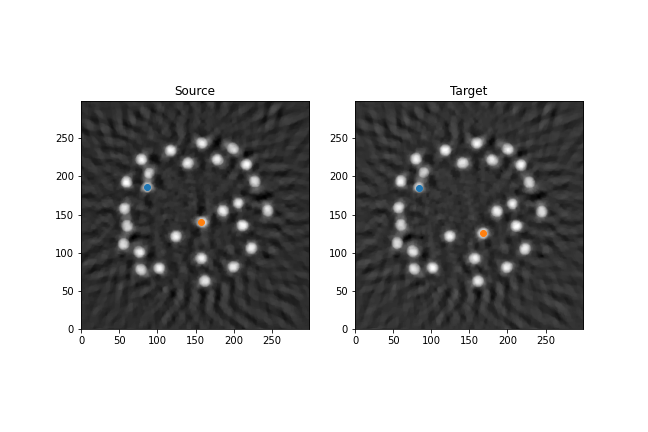

Button(description='Disconnect mpl', style=ButtonStyle())

In [25]:
import ipywidgets as ipyw
import IPython.display as Disp
%matplotlib notebook

class points_select():
    def __init__(self,im1, im2):
        self.im1 = im1
        self.im2 = im2
        self.source = []
        self.target = []
        self.fig,self.ax = plt.subplots(1,2,figsize=(9,6))
        self.ax[0].imshow(self.im1.copy(), cmap="gray", origin="lower")#, extent=[-self.im1.shape[1]/2., self.im1.shape[1]/2., -self.im1.shape[0]/2., self.im1.shape[0]/2. ])
        self.ax[0].set_title("Source")
        self.ax[1].imshow(self.im2.copy(), cmap="gray", origin="lower")#, extent=[-self.im1.shape[1]/2., self.im1.shape[1]/2., -self.im1.shape[0]/2., self.im1.shape[0]/2. ])
        self.ax[1].set_title("Target")
        self.ka = self.fig.canvas.mpl_connect('button_press_event', self.onclick)
        disconnect_button = ipyw.Button(description="Disconnect mpl")
        Disp.display(disconnect_button)
        disconnect_button.on_click(self.disconnect_mpl)
        
    def disconnect_mpl(self,_):
        self.fig.canvas.mpl_disconnect(self.ka)

    def onclick(self, event):
        ax = event.inaxes
        ax.scatter(event.xdata, event.ydata)
        if ax.title.get_text() == "Source":
            self.source.append([event.xdata, event.ydata])
        else:
            self.target.append([event.xdata, event.ydata])
        
        return

p1 = points_select(recon_t[2,:,:], recon_t[0,:,:])



In [26]:
%matplotlib inline
import sys
sys.path.append("/home/mette/github/implicitmodules")

import math

import torch
import matplotlib.pyplot as plt
import scipy.ndimage
import numpy as np
from os import listdir
from os.path import isfile, join
from tqdm import tqdm

import imodal

imodal.Utilities.set_compute_backend('torch')

source_image = torch.from_numpy(recon_t[2,:,:])
target_image = torch.from_numpy(recon_t[0,:,:])

extent = imodal.Utilities.AABB(0., 300., 0., 300.)

source_dots = torch.tensor(p1.source)

target_dots = torch.tensor(p1.target)

source_dots, target_dots

(tensor([[ 86.1151, 185.9876],
         [157.0829, 139.9900]], dtype=torch.float64),
 tensor([[ 83.5823, 184.6734],
         [167.6922, 125.5336]], dtype=torch.float64))

In [27]:
extent.totuple()

(0.0, 300.0, 0.0, 300.0)

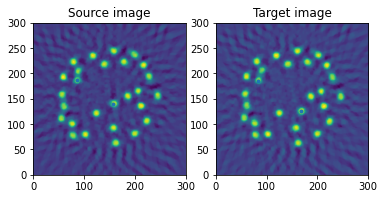

In [28]:
plt.subplot(1, 2, 1)
plt.title("Source image")
plt.imshow(source_image, extent=extent.totuple(), origin="lower")
plt.plot(source_dots.numpy()[:, 0], source_dots.numpy()[:, 1], '.')

plt.subplot(1, 2, 2)
plt.title("Target image")
plt.imshow(target_image, extent=extent.totuple(), origin="lower")
plt.plot(target_dots.numpy()[:, 0], target_dots.numpy()[:, 1], '.')

plt.show()

In [29]:
shift = target_dots-source_dots
shift

tensor([[ -2.5329,  -1.3142],
        [ 10.6093, -14.4564]], dtype=torch.float64)

In [30]:
sigma = 12.0 #determines area affected by local translation
d = 2 #dimension
p = 2 #number of sources

nu = 0.1 #regularization parameter
implicit_translation = imodal.DeformationModules.ImplicitModule0(d, p, sigma, nu=nu)

gd = source_dots
controls = shift

implicit_translation.manifold.fill_gd(gd)
implicit_translation.fill_controls(controls)

In [31]:
grid_points = imodal.Utilities.grid2vec(*torch.meshgrid([torch.linspace(0., 300., 100), torch.linspace(0., 300., 100)]))

(0.0, 300.0, 0.0, 300.0)

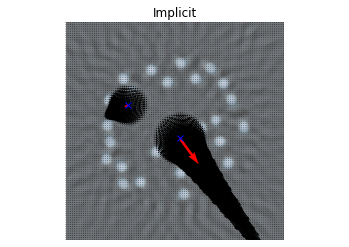

In [32]:
implicit_field = implicit_translation(grid_points)
plt.title("Implicit")
plt.quiver(grid_points[:, 0], grid_points[:, 1], implicit_field[:, 0]*0.00001, implicit_field[:, 1]*0.00001)
plt.plot(gd[:, 0], gd[:, 1], 'x', color='blue')
plt.quiver(gd[:, 0], gd[:, 1], controls[:, 0]*0.001, controls[:, 1]*0.001, color='red', lw=1.5)
plt.imshow(source_image, cmap="gray", extent=extent, alpha=0.8, origin="lower")
plt.imshow(target_image, cmap="Blues", extent=extent, alpha=0.2, origin="lower")
plt.axis('equal')
plt.axis('off')

In [33]:
source_deformable = imodal.Models.DeformableImage(source_image, output='bitmap', extent='match', backward=True)
target_deformable = imodal.Models.DeformableImage(target_image, output='bitmap', extent='match', backward=True)

source_dots_deformable = imodal.Models.DeformablePoints(source_dots)
target_dots_deformable = imodal.Models.DeformablePoints(target_dots)

attachment = imodal.Attachment.L2NormAttachment(transform=None)

model = imodal.Models.RegistrationModel([source_deformable, source_dots_deformable], [implicit_translation], [attachment, imodal.Attachment.EuclideanPointwiseDistanceAttachment()], fit_gd=[False], lam=1000.)

In [34]:
shoot_solver = 'euler'
shoot_it = 30
max_it = 15

costs = {}
fitter = imodal.Models.Fitter(model, optimizer='torch_lbfgs')

fitter.fit([target_deformable, target_dots_deformable], max_it, costs=costs, options={'shoot_solver': shoot_solver, 'shoot_it': shoot_it, 'line_search_fn': 'strong_wolfe'})

/home/mette/github/implicitmodules/imodal/DeformationModules/ImplicitModule0.py:111: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /tmp/pip-req-build-019a0thw/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  controls, _ = torch.solve(vs(self.manifold.gd), K_q)


Starting optimization with method torch LBFGS, using solver euler with 30 iterations.
Initial cost={'deformation': 0.0, 'attach': 993944.0681511059}
1e-10
Evaluated model with costs=993944.0681511059
Evaluated model with costs=984599.3226022754
Evaluated model with costs=963945.5968030326
Evaluated model with costs=947982.4507303527
Evaluated model with costs=943898.0656027943
Evaluated model with costs=928432.0157336122
Evaluated model with costs=851058.1364367381
Evaluated model with costs=755656.3566785546
Evaluated model with costs=677178.9744824216
Evaluated model with costs=635156.875776074
Evaluated model with costs=1318840.5712172682
Evaluated model with costs=558800.9971863625
Evaluated model with costs=495674.0333319935
Evaluated model with costs=492510.94459894946
Evaluated model with costs=432137.80547350954
Evaluated model with costs=431140.34058799426
Evaluated model with costs=430931.681831706
Evaluated model with costs=430919.16470176703
Evaluated model with costs=43090

Evaluated model with costs=398143.2086727017
Evaluated model with costs=398142.78599575855
Evaluated model with costs=398137.1240915593
Evaluated model with costs=398129.2105406636
Evaluated model with costs=398117.1055006615
Evaluated model with costs=398090.6720782884
Evaluated model with costs=398065.4747437631
Evaluated model with costs=398028.4961892676
Evaluated model with costs=397984.3636805187
Evaluated model with costs=397986.0784664871
Evaluated model with costs=397973.45267630415
Evaluated model with costs=397960.524057351
Evaluated model with costs=397956.45865050517
Evaluated model with costs=397951.7970227826
Evaluated model with costs=397945.26251002983
Evaluated model with costs=397982.41325230757
Evaluated model with costs=397939.40012923896
Evaluated model with costs=397931.53050660697
Evaluated model with costs=397926.9984522223
Evaluated model with costs=397924.8375259037
Evaluated model with costs=397924.2666740425
Evaluated model with costs=397924.063361911
Time:

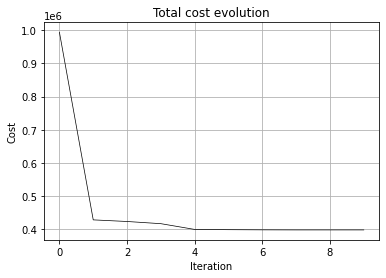

In [35]:
total_costs = [sum(cost) for cost in list(map(list, zip(*costs.values())))]

plt.title("Total cost evolution")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.grid(True)
plt.plot(range(len(total_costs)), total_costs, color='black', lw=0.7)
plt.show()

[(tensor([[ 0.0021,  0.0022,  0.0025,  ...,  0.0010,  0.0008,  0.0004],
        [ 0.0022,  0.0023,  0.0033,  ...,  0.0010,  0.0008,  0.0005],
        [ 0.0055,  0.0054,  0.0060,  ...,  0.0010,  0.0008,  0.0005],
        ...,
        [-0.0149, -0.0150, -0.0150,  ...,  0.0114,  0.0094,  0.0026],
        [-0.0149, -0.0150, -0.0157,  ...,  0.0114,  0.0094,  0.0028],
        [-0.0156, -0.0157, -0.0160,  ...,  0.0050,  0.0050,  0.0030]],
       dtype=torch.float64),), (tensor([[ 85.2336, 184.0678],
        [166.6442, 123.8789]], dtype=torch.float64),)]


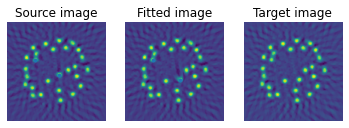

In [36]:
with torch.autograd.no_grad():
    model.deformables[0].output = 'bitmap'
    deformed = model.compute_deformed(shoot_solver, shoot_it)
    print(deformed)

    deformed_image = deformed[0][0]#.view_as(source_image)
    deformed_dots = deformed[1][0]

plt.subplot(1, 3, 1)
plt.title("Source image")
plt.imshow(source_image.numpy(), extent=extent.totuple(), origin="lower")
plt.plot(source_dots.numpy()[:, 0], source_dots.numpy()[:, 1], '.')
#plt.plot(center.numpy()[0, 0], center.numpy()[0, 1], 'X')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Fitted image")
plt.imshow(deformed_image.numpy(), extent=extent.totuple(), origin="lower")
#plt.imshow(source_image.numpy(), extent=extent.totuple(), alpha=0.5, cmap="Blues")
plt.plot(deformed_dots.numpy()[:, 0], deformed_dots.numpy()[:, 1], '.')
#plt.plot(fitted_center.numpy()[0, 0], fitted_center.numpy()[0, 1], 'X')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Target image")
plt.imshow(target_image.numpy(), extent=extent.totuple(), origin="lower")
#plt.plot(target_dots.numpy()[:, 0], target_dots.numpy()[:, 1], '.')
plt.axis('off')

plt.show()

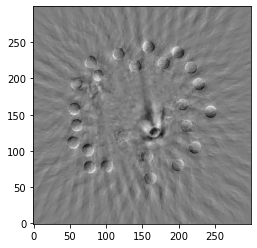

In [37]:
plt.imshow(deformed_image-target_image, origin="lower", cmap="gray")

## Determining motion model in opposite time direction

In [38]:
%matplotlib inline
source_image2 = torch.from_numpy(recon_t[0,:,:])
target_image2 = torch.from_numpy(recon_t[2,:,:])

source_dots2 = torch.tensor(p1.target)

target_dots2 = torch.tensor(p1.source)

source_dots2, target_dots2

(tensor([[ 83.5823, 184.6734],
         [167.6922, 125.5336]], dtype=torch.float64),
 tensor([[ 86.1151, 185.9876],
         [157.0829, 139.9900]], dtype=torch.float64))

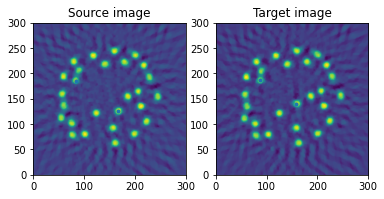

In [39]:
plt.subplot(1, 2, 1)
plt.title("Source image")
plt.imshow(source_image2, extent=extent.totuple(), origin="lower")
plt.plot(source_dots2.numpy()[:, 0], source_dots2.numpy()[:, 1], '.')

plt.subplot(1, 2, 2)
plt.title("Target image")
plt.imshow(target_image2, extent=extent.totuple(), origin="lower")
plt.plot(target_dots2.numpy()[:, 0], target_dots2.numpy()[:, 1], '.')

plt.show()

In [40]:
shift2 = target_dots2-source_dots2
shift2

tensor([[  2.5329,   1.3142],
        [-10.6093,  14.4564]], dtype=torch.float64)

In [41]:
sigma = 12.0 #determines area affected by local translation
d = 2 #dimension
p = 2 #number of sources

nu = 0.1 #regularization parameter
implicit_translation2 = imodal.DeformationModules.ImplicitModule0(d, p, sigma, nu=nu)

gd2 = source_dots2
controls2 = shift2

implicit_translation2.manifold.fill_gd(gd2)
implicit_translation2.fill_controls(controls2)

(0.0, 300.0, 0.0, 300.0)

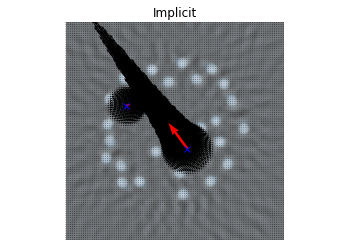

In [42]:
grid_points2 = imodal.Utilities.grid2vec(*torch.meshgrid([torch.linspace(0., 300., 100), torch.linspace(0., 300., 100)]))
implicit_field2 = implicit_translation2(grid_points2)
plt.title("Implicit")
plt.quiver(grid_points2[:, 0], grid_points2[:, 1], implicit_field2[:, 0], implicit_field2[:, 1])
plt.plot(gd2[:, 0], gd2[:, 1], 'x', color='blue')
plt.quiver(gd2[:, 0], gd2[:, 1], controls2[:, 0]*0.001, controls2[:, 1]*0.001, color='red', lw=1.5)
plt.imshow(source_image2, cmap="gray", extent=extent, alpha=0.8, origin="lower")
plt.imshow(target_image2, cmap="Blues", extent=extent, alpha=0.2, origin="lower")
plt.axis('equal')
plt.axis('off')

In [43]:
source_deformable2 = imodal.Models.DeformableImage(source_image2, output='bitmap', extent='match', backward=True)
target_deformable2 = imodal.Models.DeformableImage(target_image2, output='bitmap', extent='match', backward=True)

source_dots_deformable2 = imodal.Models.DeformablePoints(source_dots2)
target_dots_deformable2 = imodal.Models.DeformablePoints(target_dots2)

attachment2 = imodal.Attachment.L2NormAttachment(transform=None)

model2 = imodal.Models.RegistrationModel([source_deformable2, source_dots_deformable2], [implicit_translation2], [attachment2, imodal.Attachment.EuclideanPointwiseDistanceAttachment()], fit_gd=[False], lam=1000.)

In [44]:
costs2 = {}
fitter = imodal.Models.Fitter(model2, optimizer='torch_lbfgs')

fitter.fit([target_deformable2, target_dots_deformable2], max_it, costs=costs2, options={'shoot_solver': shoot_solver, 'shoot_it': shoot_it, 'line_search_fn': 'strong_wolfe'})

Starting optimization with method torch LBFGS, using solver euler with 30 iterations.
Initial cost={'deformation': 0.0, 'attach': 993944.0681511059}
1e-10
Evaluated model with costs=993944.0681511059
Evaluated model with costs=985978.6650403237
Evaluated model with costs=978832.0686977978
Evaluated model with costs=943631.423117495
Evaluated model with costs=932212.0053934231
Evaluated model with costs=929078.5655402731
Evaluated model with costs=942676.6319244129
Evaluated model with costs=927194.8551008117
Evaluated model with costs=926082.5988107484
Evaluated model with costs=925777.1088533452
Evaluated model with costs=925539.779618336
Evaluated model with costs=925534.7220531857
Evaluated model with costs=925504.1656757146
Evaluated model with costs=924853.2958963251
Evaluated model with costs=935286.8399034252
Evaluated model with costs=924039.3944887416
Evaluated model with costs=924034.8521409368
Evaluated model with costs=924030.2757497062
Evaluated model with costs=4092550.83

Evaluated model with costs=395775.7273688343
Evaluated model with costs=395581.1507734498
Evaluated model with costs=395485.3747475894
Evaluated model with costs=395321.9408727031
Evaluated model with costs=395262.20614705293
Evaluated model with costs=395209.5566169964
Evaluated model with costs=395176.992217225
Evaluated model with costs=395161.8794439812
Evaluated model with costs=395144.55806790484
Evaluated model with costs=395139.33725812787
Evaluated model with costs=395137.4104100279
Evaluated model with costs=395140.6747722075
Evaluated model with costs=395137.0137688904
Evaluated model with costs=395136.8093590057
Evaluated model with costs=395237.4407290657
Evaluated model with costs=395136.42736335454
Evaluated model with costs=395135.7353653281
Evaluated model with costs=395143.2574764902
Evaluated model with costs=395135.278057517
Evaluated model with costs=395134.9959692628
Evaluated model with costs=395134.2884391925
Time: 744.6355958000022
Iteration: 6
Costs
deformatio

Evaluated model with costs=392559.6558587152
Evaluated model with costs=392559.7334422434
Evaluated model with costs=392559.6530402189
Evaluated model with costs=392559.64887036657
Evaluated model with costs=392559.64580475906
Evaluated model with costs=392559.6448879117
Evaluated model with costs=392559.64900026785
Evaluated model with costs=392559.6442231796
Evaluated model with costs=392559.6460461582
Evaluated model with costs=392559.6443615907
Evaluated model with costs=392559.64421789
Evaluated model with costs=392559.64391277806
Evaluated model with costs=392559.6436354637
Evaluated model with costs=392559.6425804636
Evaluated model with costs=392559.640824963
Evaluated model with costs=392559.63236051676
Time: 1393.8684177569994
Iteration: 12
Costs
deformation=998.7545145324912
attach=391560.87784598424
Total cost=392559.63236051676
1e-10
Evaluated model with costs=392559.63236051676
Evaluated model with costs=392559.62668364745
Evaluated model with costs=392559.6239891794
Eval

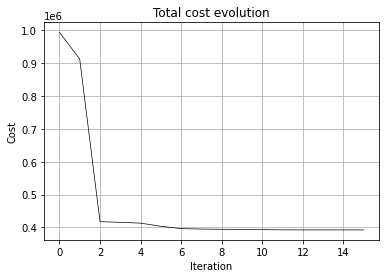

In [45]:
total_costs2 = [sum(cost) for cost in list(map(list, zip(*costs2.values())))]

plt.title("Total cost evolution")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.grid(True)
plt.plot(range(len(total_costs2)), total_costs2, color='black', lw=0.7)
plt.show()

[(tensor([[-0.0072, -0.0071,  0.0092,  ...,  0.0025,  0.0025,  0.0001],
        [-0.0073, -0.0072,  0.0100,  ...,  0.0025,  0.0025,  0.0002],
        [ 0.0006,  0.0005,  0.0106,  ...,  0.0028,  0.0027,  0.0025],
        ...,
        [-0.0121, -0.0121, -0.0316,  ...,  0.0053,  0.0046,  0.0038],
        [-0.0120, -0.0120, -0.0277,  ...,  0.0055,  0.0048,  0.0042],
        [-0.0118, -0.0118, -0.0159,  ...,  0.0057,  0.0047,  0.0043]],
       dtype=torch.float64),), (tensor([[ 86.1173, 185.9882],
        [157.2694, 140.4515]], dtype=torch.float64),)]


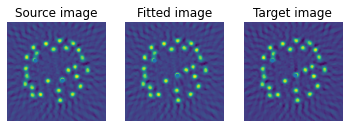

In [46]:
with torch.autograd.no_grad():
    model2.deformables[0].output = 'bitmap'
    deformed = model2.compute_deformed(shoot_solver, shoot_it)
    print(deformed)

    deformed_image = deformed[0][0]#.view_as(source_image)
    deformed_dots = deformed[1][0]

plt.subplot(1, 3, 1)
plt.title("Source image")
plt.imshow(source_image2.numpy(), extent=extent.totuple(), origin="lower")
plt.plot(source_dots2.numpy()[:, 0], source_dots2.numpy()[:, 1], '.')
#plt.plot(center.numpy()[0, 0], center.numpy()[0, 1], 'X')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Fitted image")
plt.imshow(deformed_image.numpy(), extent=extent.totuple(), origin="lower")
#plt.imshow(source_image.numpy(), extent=extent.totuple(), alpha=0.5, cmap="Blues")
plt.plot(deformed_dots.numpy()[:, 0], deformed_dots.numpy()[:, 1], '.')
#plt.plot(fitted_center.numpy()[0, 0], fitted_center.numpy()[0, 1], 'X')
#plt.plot(source_dots2.numpy()[:, 0], source_dots2.numpy()[:, 1], '.')
p#lt.plot(target_dots2.numpy()[:, 0], target_dots2.numpy()[:, 1], '.')

plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Target image")
plt.imshow(target_image2.numpy(), extent=extent.totuple(), origin="lower")
plt.plot(target_dots2.numpy()[:, 0], target_dots2.numpy()[:, 1], '.')

plt.axis('off')

plt.show()

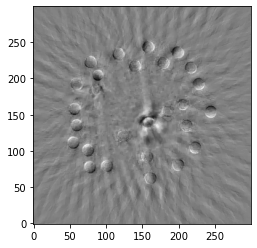

In [47]:
plt.imshow(deformed_image-target_image2, origin="lower", cmap="gray")

## Using 2 motion models to try and improve reconstruction

Make custom backprojection for raytransform given by backprojecting along curves, also determine movement in other direction to get reconstruction of center frame

In [53]:
from scipy.interpolate import interp1d
import copy 
from scipy import ndimage

def rotate_own(origin, points, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    ox, oy = origin

    qx = ox + np.cos(angle) * (points[:,0] - ox) - np.sin(angle) * (points[:,1] - oy)
    qy = oy + math.sin(angle) * (points[:,0] - ox) + math.cos(angle) * (points[:,1] - oy)
    return qy

class phi():
    def __init__(self,grid,model):
        self.grid = copy.deepcopy(grid)
        self.model = model
        
        modules = imodal.DeformationModules.CompoundModule(self.model.modules)
        modules.manifold.fill(model.init_manifold.clone())
    
        modules_grid = [*modules, self.grid]
        hamiltonian = imodal.HamiltonianDynamic.Hamiltonian(modules_grid)
    
        self.intermediates_grid = {}
        with torch.autograd.no_grad():
            imodal.HamiltonianDynamic.shoot(hamiltonian, shoot_solver, shoot_it, intermediates=self.intermediates_grid)
    
    def __getitem__(self, t):
        g = copy.deepcopy(self.grid)
        g.manifold.fill_gd(self.intermediates_grid['states'][t][-1].gd)
        return g.togrid()

def map_image(ph, image, t):
    new_x, new_y = ph[t]
    x, y = grid.togrid()
    mesh= np.stack((x.numpy().ravel(), y.numpy().ravel()), axis=0)
    new_mesh = np.stack((new_x.numpy().ravel(), new_y.numpy().ravel()), axis=0)
    mapped_image = ndimage.map_coordinates(image.transpose(), new_mesh.reshape(2,300,300), order=1)
    return mapped_image.transpose()

def backprojection(data, theta, ph, rho, t):
    x, y = ph[0]
    grid_stack = np.stack((y.numpy().transpose().ravel(), x.numpy().transpose().ravel()), axis=-1)
    origin = np.subtract((np.max(ph[0][0].numpy()), np.max(ph[0][1].numpy())), (np.min(ph[0][0].numpy()),np.min(ph[0][0].numpy())))/2
    #rotate mapped points to find out which sinogram value to backproject to which image pixel
    r = rotate_own(origin, grid_stack, theta)
    #interpolate sinogram data for given theta to be able to evaluate at found r values
    spl = interp1d(rho, data)
    backprojection=spl(r).reshape(x.shape)
    mapped_bp = map_image(ph, backprojection.transpose(), t)    
    return mapped_bp

def FilteredBackProjection(sinogram, theta, rho, M, philist, tlist):
    #reconstruction = iradon(sinogram, theta, filter='hamming', circle=False) 
    N = len(rho)
    omega = np.array(range(0,np.floor_divide(N,2)))
    omega = np.append(omega, range(-np.floor_divide(N,2),0))
    c = 0.1
    W = c + (1-c) * np.cos(2*np.pi*omega/(N-1))
    reconstruction = np.zeros((M,M))
    for i, ang in tqdm(enumerate(theta)):
        FT = np.fft.fft(sinogram[i])
        g = np.real(np.fft.ifft([W_i * np.abs(omega_i) * FT_i for W_i, omega_i, FT_i in zip(W, omega, FT) ]))
        bp = backprojection(g, ang, philist[i], rho, tlist[i])
        reconstruction += bp
    reconstruction /=len(theta)
    return reconstruction

provide list of 2 models - one for each half, img_grid, rho, t [1,2,3,4,5,...15,14,13,12...1], then shift model halfway.

In [94]:
rho = np.linspace(-75,374, 448)
thetas = np.lib.stride_tricks.sliding_window_view(thetas_all, 30)[35]


tlistforwd = list(range(30,0,-1))
grid = imodal.DeformationModules.DeformationGrid(extent, [300,300])
phiforwd = list(np.repeat(phi(grid, model),30))
recon3 = FilteredBackProjection(volume2D[35:65], thetas, rho, 300, phiforwd, tlistforwd)

tlistinv = list(range(30))
grid = imodal.DeformationModules.DeformationGrid(extent, [300,300])
phiinv = list(np.repeat(phi(grid, model2),30))
recon1 = FilteredBackProjection(volume2D[35:65], thetas, rho, 300, phiinv, tlistinv) 

halft=15
grid = imodal.DeformationModules.DeformationGrid(extent, [300,300])
tlist = tlistforwd[:16] + tlistinv[:-15]
philist = phiforwd[:16]+phiinv[:-15]
recon2 = FilteredBackProjection(volume2D[35:65], thetas, rho, 300, philist, tlist)


30it [00:00, 64.83it/s]
30it [00:00, 64.34it/s]
30it [00:00, 64.91it/s]


In [95]:
ground_truth = load_volume("../PhantomGenerator/output/slow_fast_no_rotation")[strt_stp_idx:-strt_stp_idx,106:406,106:406]
GT =np.array([ground_truth[20], ground_truth[35], ground_truth[50],  ground_truth[50]])

240it [00:00, 507.92it/s]


/home/mette/anaconda3/envs/py38/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  func(*args, **kwargs)
/home/mette/anaconda3/envs/py38/lib/python3.8/site-packages/IPython/core/pylabtools.py:134: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


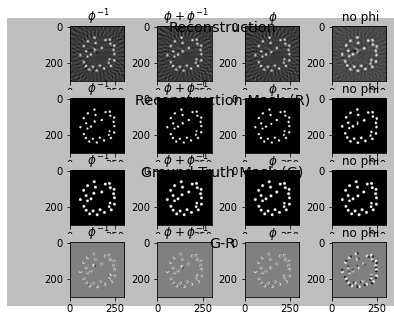

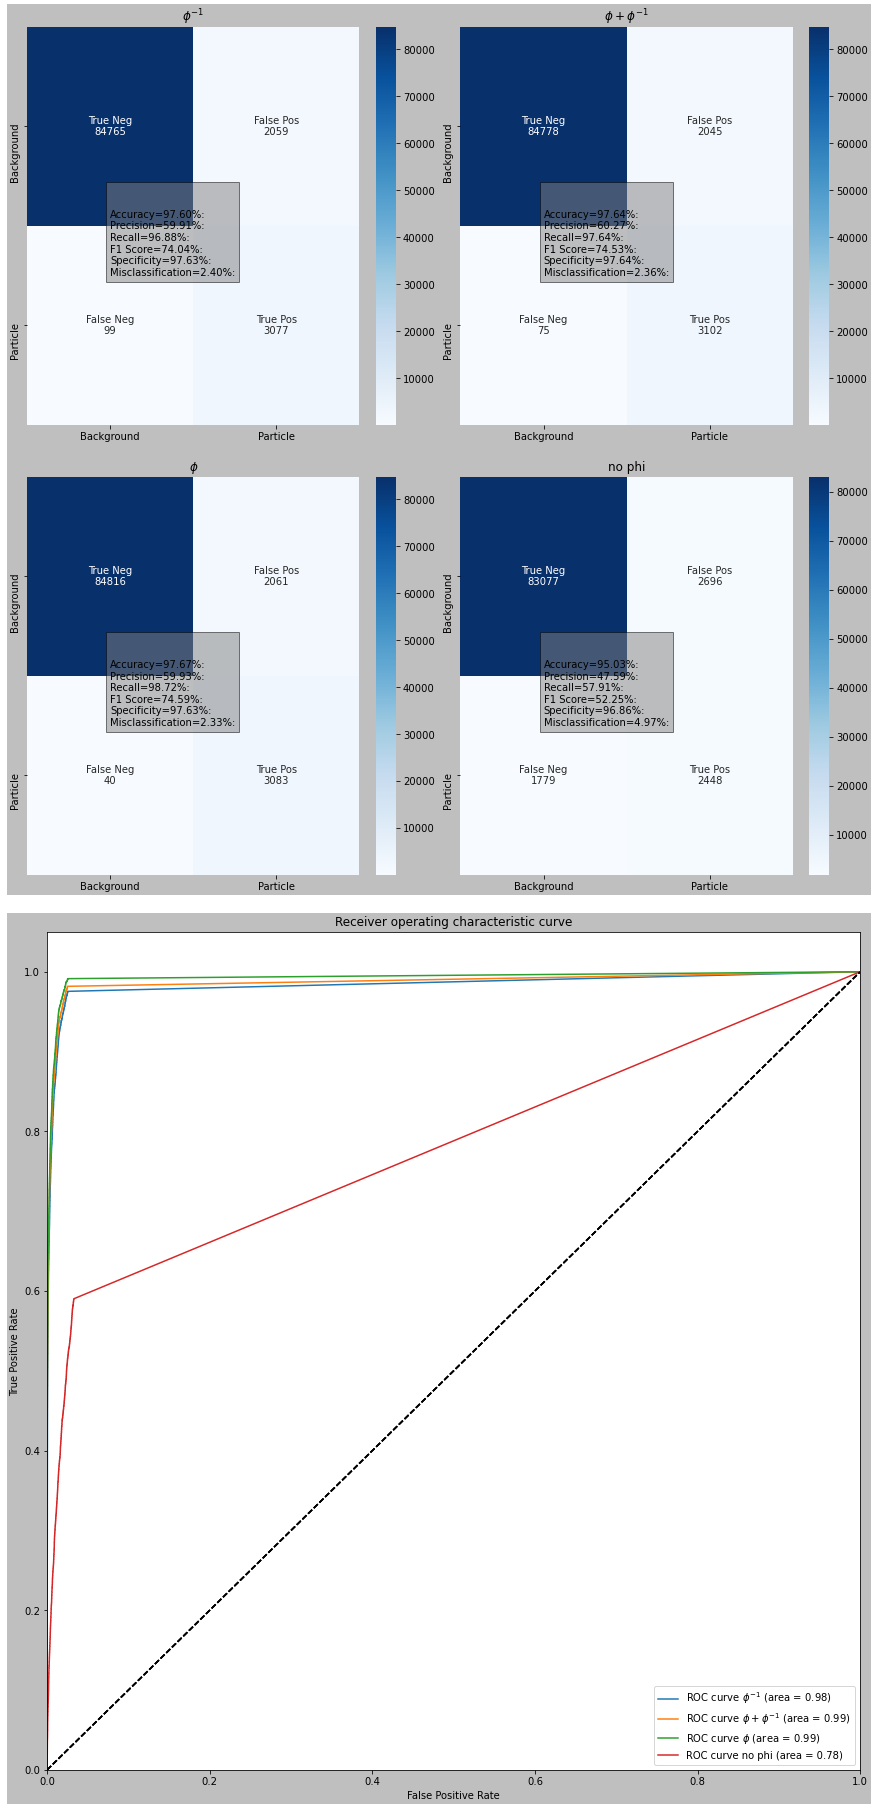

In [96]:
from plot_utils import *
def rescale(arr):
    return (arr-np.min(arr))/(np.max(arr)-np.min(arr))

recons = np.array([recon1, recon2, recon3, recon_t[1,:,:]])
recons = np.flip(recons, axis=2)
titles = [r'$\phi^{-1}$', r'$\phi+\phi^{-1}$', r'$\phi$', "no phi"]
                                  
plot_results(recons, GT , titles, threshold_minimum, threshold_minimum)
plot_stats(recons, GT, titles, threshold_minimum, threshold_minimum)
